# Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels.api as sm
from fbprophet import Prophet
from pandas.plotting import lag_plot
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

Importing plotly failed. Interactive plots will not work.


# Case 1

## Análise exploratória

In [2]:
df = pd.read_csv('TFP.csv')

In [3]:
df

,isocode,year,rtfpna
0,USA,1950,0.617148
1,USA,1951,0.629588
2,USA,1952,0.638451
3,USA,1953,0.651858
4,USA,1954,0.646179
...,...,...,...
181,MEX,2007,1.013673
182,MEX,2008,0.991548
183,MEX,2009,0.915879
184,MEX,2010,0.941604


In [4]:
mask1 = df['isocode'] == 'USA'
mask2 = df['isocode'] == 'CAN'
mask3 = df['isocode'] == 'MEX'

In [5]:
df_usa = df[mask1].drop(columns=['isocode'])
df_can = df[mask2].drop(columns=['isocode'])
df_mex = df[mask3].drop(columns=['isocode'])

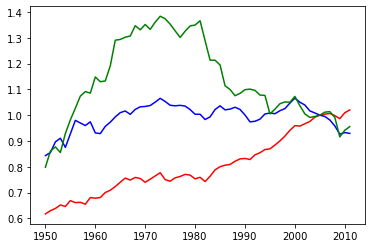

In [6]:
plt.plot(df_usa['year'], df_usa['rtfpna'], 'r-', df_can['year'], df_can['rtfpna'], 'blue', df_mex['year'], df_mex['rtfpna'], 'green')
plt.show()

<b>Podemos ver que  o México possui uma grande variação em relação ao Canadá que é uma versão mais "achatada" da curva do México. Já o dos Estados Unidos, podemos ver que a curva é crescente ao analisar individualmente.</b>

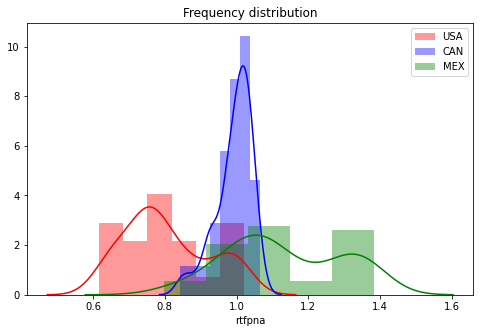

In [7]:
plt.figure(figsize=(8,5))
sns.distplot(df_usa['rtfpna'], color='red',label='USA')
sns.distplot(df_can['rtfpna'], color='blue',label='CAN')
sns.distplot(df_mex['rtfpna'], color='green',label='MEX')
plt.legend()
plt.title('Frequency distribution')
#plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.show()

<b>É possível observar que há uma quantidade de frequência maior nos dados do Canadá em comparação aos demais países.</b>

## Forecast - Individual

In [8]:
df_usa = df_usa.rename({'year':'ds','rtfpna':'y'},axis=1)
df_can = df_can.rename({'year':'ds','rtfpna':'y'},axis=1)
df_mex = df_mex.rename({'year':'ds','rtfpna':'y'},axis=1)

In [9]:
df_usa.ds = pd.to_datetime(df_usa.ds, format='%Y')
df_can.ds = pd.to_datetime(df_can.ds, format='%Y')
df_mex.ds = pd.to_datetime(df_mex.ds, format='%Y')

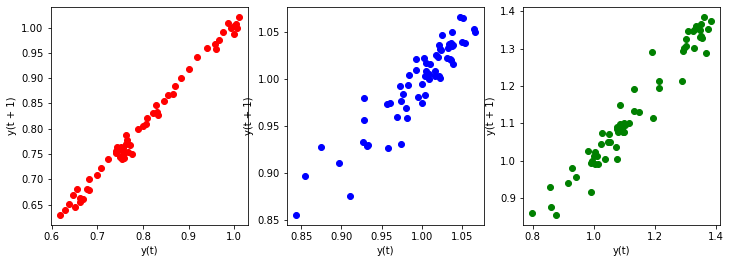

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(12,4))
lag_plot(df_usa['y'], c='red', ax = ax[0])
lag_plot(df_can['y'], c='blue', ax = ax[1])
lag_plot(df_mex['y'], c='green', ax = ax[2])

<b>No lag plot, podemos verificar se existe uma relação entre o período anterior com o período seguinte.

Podemos dizer que nos USA existe uma forte relação entre o período anterior com o período seguinte mais forte do que os demais países que estamos analisando.</b>

### USA

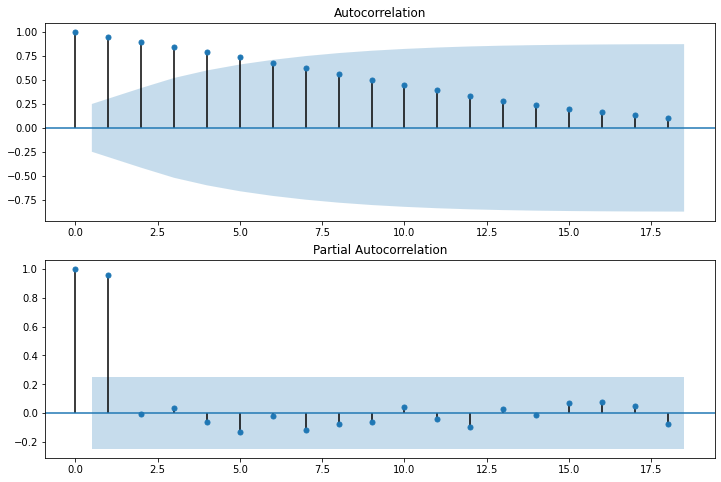

In [11]:
fig, ax = plt.subplots(2, 1,figsize=(12,8))
plot_acf(x=df_usa.y, ax=ax[0])
plot_pacf(x=df_usa.y, ax=ax[1]);

<b>O "pirulito" de número 6 entra na faixa, então vamos adicionar o período de número 6 para realizar o forecast.</b>

Decomposing a time series into:
    
- Mean
- Trends
- Seasonal Effects
- Noise

In [12]:
res = sm.tsa.seasonal_decompose(df_usa['y'], period=6)
observed = res.observed
seasonal = res.seasonal
residual = res.resid
trend = res.trend

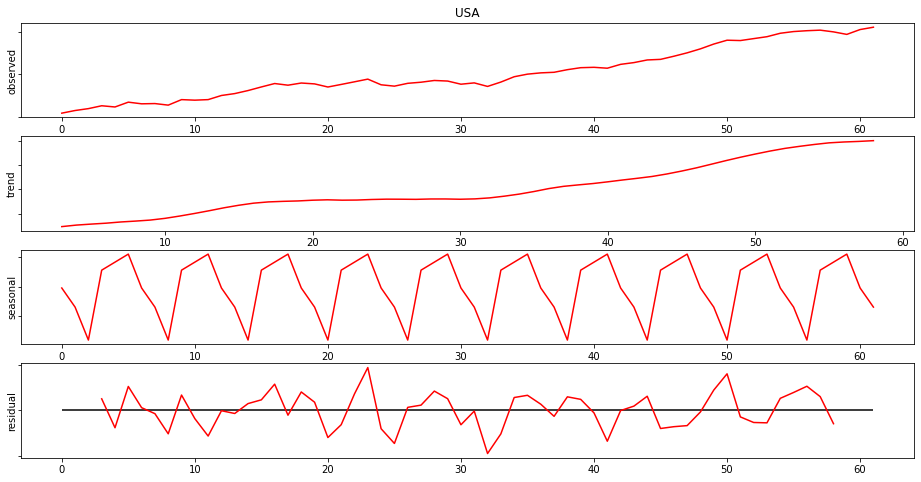

In [13]:
df_res = pd.DataFrame({"observed":observed,"trend":trend, "seasonal":seasonal,"residual":residual})
plt.figure(figsize=(16,8))

plt.subplot(411)
sns.lineplot(x=df_res.index, y='observed', data=df_res, color ='red')
plt.title('USA')
plt.tick_params(axis='y', which='both', bottom=False, top=False, labelleft=False)

plt.subplot(412)
sns.lineplot(x=df_res.index, y='trend', data=df_res, color ='red')
plt.tick_params(axis='y', which='both', bottom=False, top=False, labelleft=False)

plt.subplot(413)
sns.lineplot(x=df_res.index, y='seasonal', data=df_res, color ='red')
plt.tick_params(axis='y', which='both', bottom=False, top=False, labelleft=False)

plt.subplot(414)
sns.lineplot(x=df_res.index, y='residual', data=df_res, color ='red')
plt.tick_params(axis='y', which='both', bottom=False, top=False, labelleft=False)
plt.hlines(y=0,xmin=df_res.index.min(), xmax=df_res.index.max())
plt.show()

<b> Ao realizar a decomposição, podemos observar que a linha de observado e a linha de tendência possuem uma forte relação. No caso do gráfico de sazonalidade, podemos ver um certo padrão. Enquanto o residual, podemos ver que desde o início há uma certa variação nos valores, indicando o valor dos erros.

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


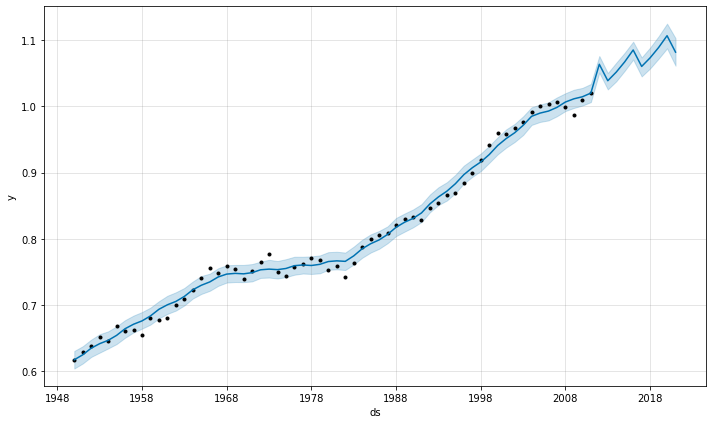

In [14]:
model = Prophet(changepoint_range=1)
model.fit(df_usa) #df_usa.iloc[30:,:]
future = model.make_future_dataframe(periods=10,freq='Y')
forecast_usa = model.predict(future)
forecast_plot = model.plot(forecast_usa)

In [15]:
forecast_usa

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1950-01-01,0.151957,0.604092,0.630652,0.151957,0.151957,0.465383,0.465383,0.465383,0.465383,0.465383,0.465383,0.0,0.0,0.0,0.617340
1,1951-01-01,0.159292,0.611746,0.637770,0.159292,0.159292,0.465568,0.465568,0.465568,0.465568,0.465568,0.465568,0.0,0.0,0.0,0.624861
2,1952-01-01,0.166628,0.621649,0.647816,0.166628,0.166628,0.468251,0.468251,0.468251,0.468251,0.468251,0.468251,0.0,0.0,0.0,0.634879
3,1953-01-01,0.173983,0.628122,0.655941,0.173983,0.173983,0.467702,0.467702,0.467702,0.467702,0.467702,0.467702,0.0,0.0,0.0,0.641685
4,1954-01-01,0.181319,0.634457,0.660288,0.181319,0.181319,0.465383,0.465383,0.465383,0.465383,0.465383,0.465383,0.0,0.0,0.0,0.646702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,2016-12-31,0.586995,1.045373,1.073958,0.580528,0.592779,0.473422,0.473422,0.473422,0.473422,0.473422,0.473422,0.0,0.0,0.0,1.060417
68,2017-12-31,0.592388,1.057411,1.088928,0.584307,0.600042,0.481063,0.481063,0.481063,0.481063,0.481063,0.481063,0.0,0.0,0.0,1.073451
69,2018-12-31,0.597781,1.072109,1.105932,0.587853,0.607489,0.491157,0.491157,0.491157,0.491157,0.491157,0.491157,0.0,0.0,0.0,1.088938
70,2019-12-31,0.603173,1.087689,1.125057,0.590820,0.615226,0.503678,0.503678,0.503678,0.503678,0.503678,0.503678,0.0,0.0,0.0,1.106851


<b>Podemos analisar no forecast, uma tendência de variação de acordo com o gráfico, mas ao ver os valores de um ano pro outro, é possivel ver que a diferença entre os valores de 2019 e 2020 é de 0.026115.</b>

### CAN

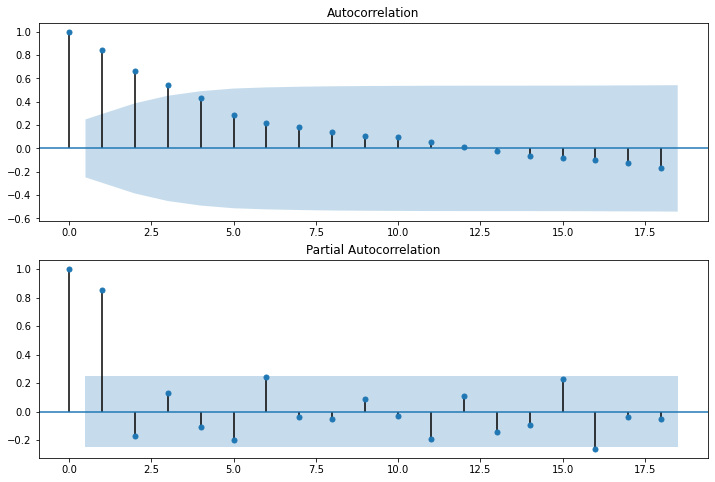

In [16]:
fig, ax = plt.subplots(2, 1,figsize=(12,8))
plot_acf(x=df_can.y, ax=ax[0])
plot_pacf(x=df_can.y, ax=ax[1]);

<b>No caso do Canadá, vamos utilizar o número 4 como período de forecast, pois o 'pirulito' de número quatro entrou na área.</b>

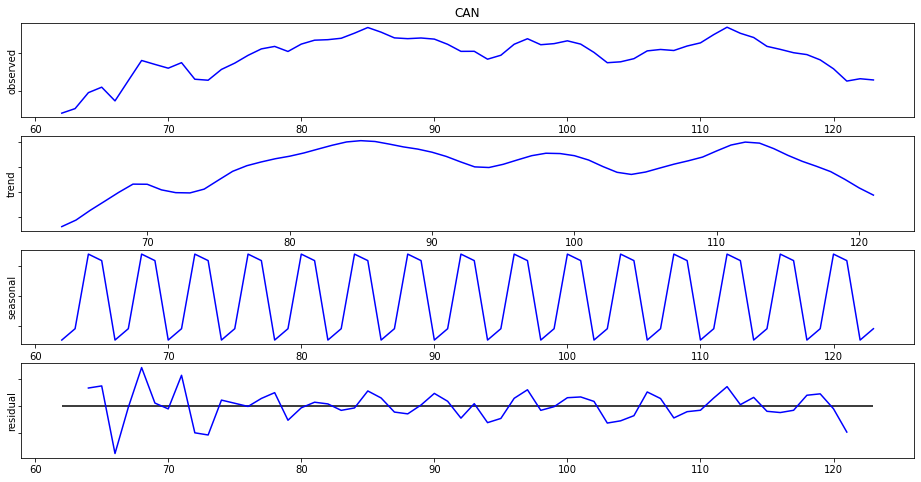

In [17]:
res = sm.tsa.seasonal_decompose(df_can['y'], period=4)
observed = res.observed
seasonal = res.seasonal
residual = res.resid
trend = res.trend

df_res = pd.DataFrame({"observed":observed,"trend":trend, "seasonal":seasonal,"residual":residual})
plt.figure(figsize=(16,8))

plt.subplot(411)
sns.lineplot(x=df_res.index, y='observed', data=df_res, color ='blue')
plt.title('CAN')
plt.tick_params(axis='y', which='both', bottom=False, top=False, labelleft=False)

plt.subplot(412)
sns.lineplot(x=df_res.index, y='trend', data=df_res, color ='blue')
plt.tick_params(axis='y', which='both', bottom=False, top=False, labelleft=False)

plt.subplot(413)
sns.lineplot(x=df_res.index, y='seasonal', data=df_res, color ='blue')
plt.tick_params(axis='y', which='both', bottom=False, top=False, labelleft=False)

plt.subplot(414)
sns.lineplot(x=df_res.index, y='residual', data=df_res, color ='blue')
plt.tick_params(axis='y', which='both', bottom=False, top=False, labelleft=False)
plt.hlines(y=0,xmin=df_res.index.min(), xmax=df_res.index.max())
plt.show()

<b>No caso do Canadá,a linha de tendência e a observada são bem similares apesar da variação e uma alta sazonalidade. Já no valor residual, podemos ver que há uma grande variação dos valores no início e nos demais anos estão com menos variação.</b>

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


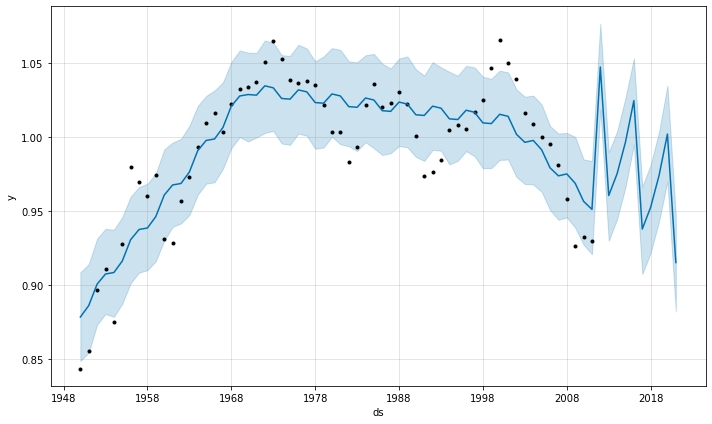

In [18]:
model = Prophet(changepoint_range=1)
model.fit(df_can)
future = model.make_future_dataframe(periods=10,freq='Y')
forecast_can = model.predict(future)
forecast_plot = model.plot(forecast_can)
#components_plot_forecast = model.plot_components(forecast)

In [19]:
forecast_can

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1950-01-01,0.365645,0.848470,0.908513,0.365645,0.365645,0.512591,0.512591,0.512591,0.512591,0.512591,0.512591,0.0,0.0,0.0,0.878236
1,1951-01-01,0.373179,0.854173,0.914060,0.373179,0.373179,0.512818,0.512818,0.512818,0.512818,0.512818,0.512818,0.0,0.0,0.0,0.885997
2,1952-01-01,0.380713,0.873091,0.931363,0.380713,0.380713,0.519804,0.519804,0.519804,0.519804,0.519804,0.519804,0.0,0.0,0.0,0.900516
3,1953-01-01,0.388267,0.880325,0.937968,0.388267,0.388267,0.519123,0.519123,0.519123,0.519123,0.519123,0.519123,0.0,0.0,0.0,0.907390
4,1954-01-01,0.395801,0.878378,0.937314,0.395801,0.395801,0.512591,0.512591,0.512591,0.512591,0.512591,0.512591,0.0,0.0,0.0,0.908392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,2016-12-31,0.404311,0.907292,0.966435,0.399599,0.408764,0.533534,0.533534,0.533534,0.533534,0.533534,0.533534,0.0,0.0,0.0,0.937845
68,2017-12-31,0.398640,0.921821,0.981358,0.392490,0.404343,0.553984,0.553984,0.553984,0.553984,0.553984,0.553984,0.0,0.0,0.0,0.952624
69,2018-12-31,0.392969,0.943047,1.003710,0.385294,0.399948,0.581117,0.581117,0.581117,0.581117,0.581117,0.581117,0.0,0.0,0.0,0.974086
70,2019-12-31,0.387298,0.970034,1.035000,0.378006,0.395964,0.614884,0.614884,0.614884,0.614884,0.614884,0.614884,0.0,0.0,0.0,1.002181


<b>Para o forecast, podemos ver no gráfico que há uma enorme variação, mas ao ver os valores de 2018, que foi de 0.974086 e de 2019 que foi de 1.002181, mostra que a variação não é tão drástica quanto aparente.</b>

### MEX

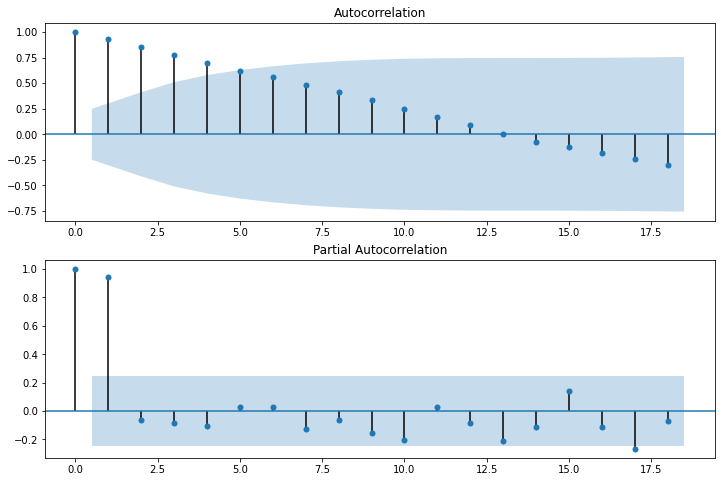

In [20]:
fig, ax = plt.subplots(2, 1,figsize=(12,8))
plot_acf(x=df_mex.y, ax=ax[0])
plot_pacf(x=df_mex.y, ax=ax[1]);

<b>Para o México, vamos utilizar o número 5 como período de frequência para realizar o forecast.</b>

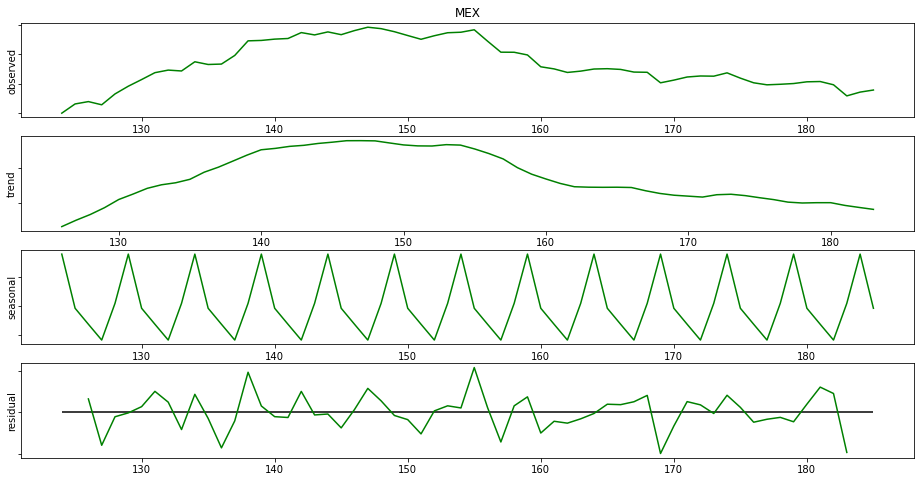

In [21]:
res = sm.tsa.seasonal_decompose(df_mex['y'], period=5)
observed = res.observed
seasonal = res.seasonal
residual = res.resid
trend = res.trend

df_res = pd.DataFrame({"observed":observed,"trend":trend, "seasonal":seasonal,"residual":residual})
plt.figure(figsize=(16,8))

plt.subplot(411)
sns.lineplot(x=df_res.index, y='observed', data=df_res, color ='green')
plt.title('MEX')
plt.tick_params(axis='y', which='both', bottom=False, top=False, labelleft=False)

plt.subplot(412)
sns.lineplot(x=df_res.index, y='trend', data=df_res, color ='green')
plt.tick_params(axis='y', which='both', bottom=False, top=False, labelleft=False)

plt.subplot(413)
sns.lineplot(x=df_res.index, y='seasonal', data=df_res, color ='green')
plt.tick_params(axis='y', which='both', bottom=False, top=False, labelleft=False)

plt.subplot(414)
sns.lineplot(x=df_res.index, y='residual', data=df_res, color ='green')
plt.tick_params(axis='y', which='both', bottom=False, top=False, labelleft=False)
plt.hlines(y=0,xmin=df_res.index.min(), xmax=df_res.index.max())
plt.show()

<b>O gráfico residual do México se parecem muito com o dos Estados Unidos, onde há uma grande variação entre os valores ao longo do período. Já os demais gráficos se parecem mais com o do Canadá, onde é uma curva crescente e decrescente ao longo dos anos.</b>

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


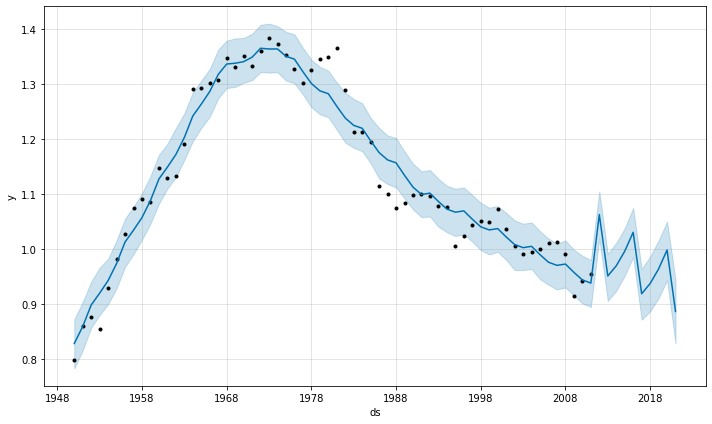

In [22]:
model = Prophet(changepoint_range=1)
model.fit(df_mex)
future = model.make_future_dataframe(periods=10,freq='Y')
forecast_mex = model.predict(future)
forecast_plot = model.plot(forecast_mex)
#components_plot_forecast = model.plot_components(forecast)

In [23]:
forecast_mex

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1950-01-01,0.424600,0.783089,0.872407,0.424600,0.424600,0.403982,0.403982,0.403982,0.403982,0.403982,0.403982,0.0,0.0,0.0,0.828582
1,1951-01-01,0.453215,0.816304,0.904392,0.453215,0.453215,0.406352,0.406352,0.406352,0.406352,0.406352,0.406352,0.0,0.0,0.0,0.859567
2,1952-01-01,0.481830,0.857307,0.941061,0.481830,0.481830,0.416801,0.416801,0.416801,0.416801,0.416801,0.416801,0.0,0.0,0.0,0.898631
3,1953-01-01,0.510523,0.880316,0.966467,0.510523,0.510523,0.409690,0.409690,0.409690,0.409690,0.409690,0.409690,0.0,0.0,0.0,0.920212
4,1954-01-01,0.539137,0.900149,0.982771,0.539137,0.539137,0.403982,0.403982,0.403982,0.403982,0.403982,0.403982,0.0,0.0,0.0,0.943119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,2016-12-31,0.483786,0.871825,0.964281,0.465560,0.498857,0.435317,0.435317,0.435317,0.435317,0.435317,0.435317,0.0,0.0,0.0,0.919103
68,2017-12-31,0.475738,0.886966,0.986918,0.453455,0.495687,0.461872,0.461872,0.461872,0.461872,0.461872,0.461872,0.0,0.0,0.0,0.937610
69,2018-12-31,0.467691,0.911068,1.015848,0.439457,0.493290,0.496423,0.496423,0.496423,0.496423,0.496423,0.496423,0.0,0.0,0.0,0.964114
70,2019-12-31,0.459643,0.943616,1.050370,0.425571,0.490826,0.538915,0.538915,0.538915,0.538915,0.538915,0.538915,0.0,0.0,0.0,0.998557


<b>Similar aos demais países, a variação é bem pequena nos valores, mesmo que no gráfico aparenta ser um valor grande.</b>

## Forecast - Geral

In [24]:
forecast_usa

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1950-01-01,0.151957,0.604092,0.630652,0.151957,0.151957,0.465383,0.465383,0.465383,0.465383,0.465383,0.465383,0.0,0.0,0.0,0.617340
1,1951-01-01,0.159292,0.611746,0.637770,0.159292,0.159292,0.465568,0.465568,0.465568,0.465568,0.465568,0.465568,0.0,0.0,0.0,0.624861
2,1952-01-01,0.166628,0.621649,0.647816,0.166628,0.166628,0.468251,0.468251,0.468251,0.468251,0.468251,0.468251,0.0,0.0,0.0,0.634879
3,1953-01-01,0.173983,0.628122,0.655941,0.173983,0.173983,0.467702,0.467702,0.467702,0.467702,0.467702,0.467702,0.0,0.0,0.0,0.641685
4,1954-01-01,0.181319,0.634457,0.660288,0.181319,0.181319,0.465383,0.465383,0.465383,0.465383,0.465383,0.465383,0.0,0.0,0.0,0.646702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,2016-12-31,0.586995,1.045373,1.073958,0.580528,0.592779,0.473422,0.473422,0.473422,0.473422,0.473422,0.473422,0.0,0.0,0.0,1.060417
68,2017-12-31,0.592388,1.057411,1.088928,0.584307,0.600042,0.481063,0.481063,0.481063,0.481063,0.481063,0.481063,0.0,0.0,0.0,1.073451
69,2018-12-31,0.597781,1.072109,1.105932,0.587853,0.607489,0.491157,0.491157,0.491157,0.491157,0.491157,0.491157,0.0,0.0,0.0,1.088938
70,2019-12-31,0.603173,1.087689,1.125057,0.590820,0.615226,0.503678,0.503678,0.503678,0.503678,0.503678,0.503678,0.0,0.0,0.0,1.106851


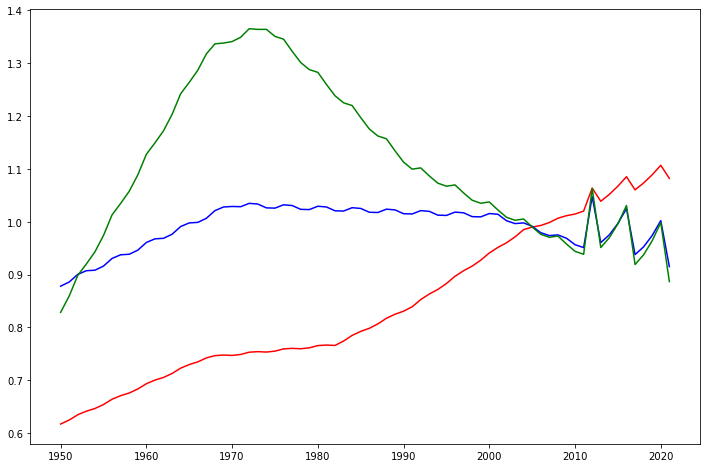

In [25]:
fig= plt.subplots(figsize=(12,8))
plt.plot(forecast_usa.ds, forecast_usa.yhat, 'r-', forecast_can.ds, forecast_can.yhat, 'blue', forecast_mex.ds, forecast_mex.yhat, 'green')
plt.show()

# CASE 2

## Evolução das exportações totais mensais e anuais totais do Brasil.

In [79]:
df = pd.read_csv('data_comexstat.csv', encoding='latin-1')
df

,date,product,state,country,type,route,tons,usd
0,1997-01-01,corn,ES,United States,Import,Sea,44.045,113029.0
1,1997-01-01,corn,GO,Argentina,Import,Ground,54.000,36720.0
2,1997-01-01,corn,GO,Bolivia,Export,Ground,0.200,180.0
3,1997-01-01,corn,GO,United States,Export,Sea,3.488,5688.0
4,1997-01-01,corn,MG,Argentina,Import,Ground,27.000,18630.0
...,...,...,...,...,...,...,...,...
117960,2019-12-01,wheat,SP,Argentina,Import,Sea,87124.765,17897516.0
117961,2019-12-01,wheat,SP,Ireland,Export,Sea,0.500,477.0
117962,2019-12-01,wheat,SP,Lebanon,Import,Sea,5.769,6726.0
117963,2019-12-01,wheat,SP,Liberia,Export,Other,0.025,50.0


In [80]:
mask = df['type'] == 'Export'
df = df[mask]

In [81]:
df['date'] = pd.to_datetime(df['date'])

C:\Users\yukar\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [82]:
df['product'].unique()

array(['corn', 'soybean_meal', 'soybean_oil', 'soybeans', 'sugar',
       'wheat'], dtype=object)

### Total Mensal

In [83]:
mask1 = df['product'] == 'soybeans'
mask2 = df['product'] == 'soybean_oil'
mask3 = df['product'] == 'soybean_meal'

df_soybeans_month = df[mask1]
df_soybean_oil_month = df[mask2]
df_soybean_meal_month = df[mask3]

In [84]:
df_soybeans_month = df_soybeans_month.groupby('date')[['tons']].sum().reset_index()
df_soybean_oil_month = df_soybean_oil_month.groupby('date')[['tons']].sum().reset_index()
df_soybean_meal_month = df_soybean_meal_month.groupby('date')[['tons']].sum().reset_index()

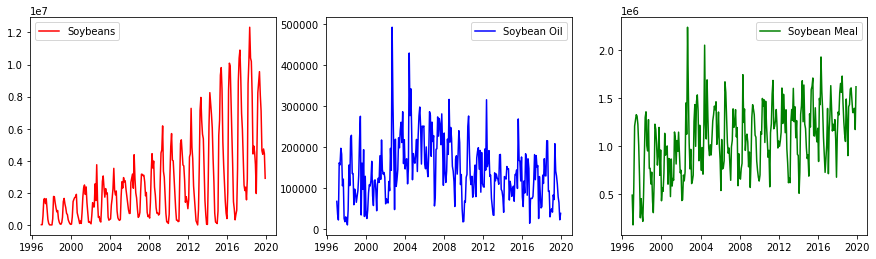

In [85]:
fig, ax = plt.subplots(1, 3, figsize=(15,4))
ax[0].plot(df_soybeans_month['date'], df_soybeans_month['tons'], 'r-')
ax[0].legend(['Soybeans'])

ax[1].plot(df_soybean_oil_month['date'], df_soybean_oil_month['tons'], 'blue')
ax[1].legend(['Soybean Oil'])

ax[2].plot(df_soybean_meal_month['date'], df_soybean_meal_month['tons'], 'green')
ax[2].legend(['Soybean Meal'])
plt.show()

<b>Ao colocar os gráficos lado a lado, podemos ver que a escala dos produtos estão bem parecidas caso não tenha o cuidado para ver que no eixo-y há uma grande diferença na quantidade de soja e a farinha de soja.</b>

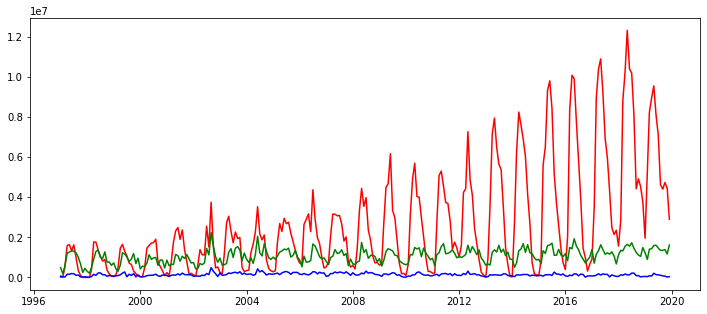

In [86]:
fig = plt.subplots(figsize=(12,5))
plt.plot(df_soybeans_month['date'], df_soybeans_month['tons'], 'r-', df_soybean_oil_month['date'], df_soybean_oil_month['tons'], 'blue', df_soybean_meal_month['date'], df_soybean_meal_month['tons'], 'green', )
plt.show()

### Total Anual

In [87]:
df = df.reset_index().drop(columns=['index'])

In [88]:
df

,date,product,state,country,type,route,tons,usd
0,1997-01-01,corn,GO,Bolivia,Export,Ground,0.200,180.0
1,1997-01-01,corn,GO,United States,Export,Sea,3.488,5688.0
2,1997-01-01,corn,MS,Paraguay,Export,Ground,40.000,38700.0
3,1997-01-01,corn,PR,Netherlands,Export,Sea,170000.000,20000000.0
4,1997-01-01,corn,PR,Paraguay,Export,Ground,258.300,386733.0
...,...,...,...,...,...,...,...,...
105856,2019-12-01,wheat,PR,United States,Export,Sea,0.400,400.0
105857,2019-12-01,wheat,RS,Vietnam,Export,Sea,36698.000,6963002.0
105858,2019-12-01,wheat,SP,Ireland,Export,Sea,0.500,477.0
105859,2019-12-01,wheat,SP,Liberia,Export,Other,0.025,50.0


In [92]:
df['year'] = 0
for item in range(0, 105861):
    df['year'][item] = df['date'][item].year

C:\Users\yukar\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [93]:
df

,date,product,state,country,type,route,tons,usd,year
0,1997-01-01,corn,GO,Bolivia,Export,Ground,0.200,180.0,1997
1,1997-01-01,corn,GO,United States,Export,Sea,3.488,5688.0,1997
2,1997-01-01,corn,MS,Paraguay,Export,Ground,40.000,38700.0,1997
3,1997-01-01,corn,PR,Netherlands,Export,Sea,170000.000,20000000.0,1997
4,1997-01-01,corn,PR,Paraguay,Export,Ground,258.300,386733.0,1997
...,...,...,...,...,...,...,...,...,...
105856,2019-12-01,wheat,PR,United States,Export,Sea,0.400,400.0,2019
105857,2019-12-01,wheat,RS,Vietnam,Export,Sea,36698.000,6963002.0,2019
105858,2019-12-01,wheat,SP,Ireland,Export,Sea,0.500,477.0,2019
105859,2019-12-01,wheat,SP,Liberia,Export,Other,0.025,50.0,2019


In [94]:
mask1 = df['product'] == 'soybeans'
mask2 = df['product'] == 'soybean_oil'
mask3 = df['product'] == 'soybean_meal'

df_soybeans_year = df[mask1]
df_soybean_oil_year = df[mask2]
df_soybean_meal_year = df[mask3]

In [95]:
df_soybeans_year = df_soybeans_year.groupby('year')[['tons']].sum().reset_index()
df_soybean_oil_year = df_soybean_oil_year.groupby('year')[['tons']].sum().reset_index()
df_soybean_meal_year = df_soybean_meal_year.groupby('year')[['tons']].sum().reset_index()

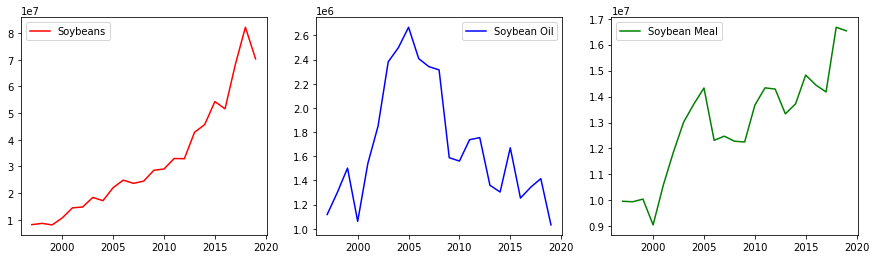

In [96]:
fig, ax = plt.subplots(1, 3, figsize=(15,4))
ax[0].plot(df_soybeans_year['year'], df_soybeans_year['tons'], 'r-')
ax[0].legend(['Soybeans'])

ax[1].plot(df_soybean_oil_year['year'], df_soybean_oil_year['tons'], 'blue')
ax[1].legend(['Soybean Oil'])

ax[2].plot(df_soybean_meal_year['year'], df_soybean_meal_year['tons'], 'green')
ax[2].legend(['Soybean Meal'])
plt.show()

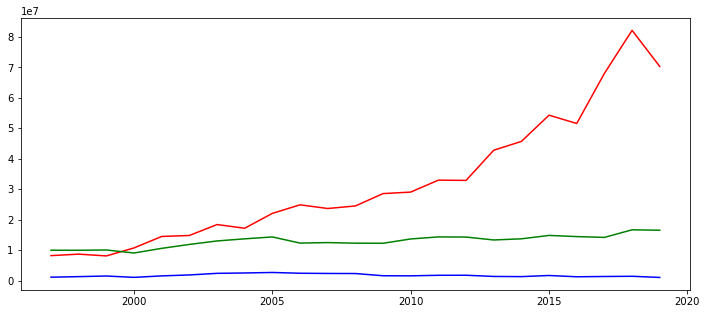

In [97]:
fig = plt.subplots(figsize=(12,5))
plt.plot(df_soybeans_year['year'], df_soybeans_year['tons'], 'r-', 
         df_soybean_oil_year['year'], df_soybean_oil_year['tons'], 'blue', 
         df_soybean_meal_year['year'], df_soybean_meal_year['tons'], 'green', )
plt.show()

## Os 3 produtos mais importantes exportados pelo Brasil

In [113]:
mask_5 = (df['year'] <= 2019) & (df['year'] >= 2015)
df_5 = df[mask_5]

In [114]:
export = df_5.groupby('product')[['tons']].sum().reset_index().sort_values(by='tons', ascending=False)

In [115]:
export.head(3)

,product,tons
3,soybeans,3.263315e+08
0,corn,1.445993e+08
4,sugar,1.200336e+08
